# Movie Recommender System - Thirteen Analytics Consulting

© Explore Data Science Academy

---

<img alt="Movie recommendations" src="https://github.com/Explore-AI/unsupervised-predict-streamlit-template/raw/master/resources/imgs/Image_header.png">

## Introduction

In the 21st century, recommender systems have proven to be socially and economically critical in the optimization of decision making around daily tasks. The notion is to create a seamless process that increases the chance of going with the best choice in every scenario. The application of recommender system is pronounced in email spam classification and movie title selections. In this project, the goal is to develop a model that can help viewers get the best title from thousands of movie titles.  

The key objectives of the project include:
* Develop a recommendation algorithm based on content or collaborative filtering. 
* The model predict how an individual will rate a movie based on historical movie selection patterns.
* The model should demonstrate the potential to be applied to create an economically robust system that enables users to have a personalized recommendaation system for a daily use. 

### Types of Recommender Systems

In general there are three types of recommender systems namely Demographic Filtering, Content Based Filtering and Collaborative Filtering. <br>

***Demographic Filtering***<br>
They are designed to offer general recommendation to every user based on the genre and/or popularity of the movie. The system provides the same recommendation to users with similar demographic features.  It is a naive approach because of every user is unique. The key reasoning behind the development of a demographic filtering system is that popular movies are likely to have a higher probability of beng liked by the average group of users. <br>

***Content Based Filtering***<br>
The system suggests similar items based on distinct item. It relies on item metadata like genre, director, description, actors etc to make recommendations for movies. The notion behind the system is that an individual who likes the distinct item is more likely to like an item that is similar to it. For example, a user who likes Big Bang Theory is likely to like other comedy shows associated with Chuck Lorre. <br>

***Collaborative Filtering***<br>
It matches the users with similar interests and provides recommendations based on this matching. Collaborative based filtering systems do not rely on metadata like content based systems. <br>


## Comet API

Comet is a version control system for machine learning models. Each project is made of experiments that keep record of all the libraries and actions taken to get to the final model. 

In [1]:
# # import comet_ml at the top of your file
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="pRMxFxeNwUPYOyNGu3BPn91GY",
#     project_name="movie-recommender",
#     workspace="jakam",
# )

## Importing Packages

In [2]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from datetime import datetime
import re

# Modelling Libraries
import surprise
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD
from surprise import KNNWithZScore,KNNBaseline,SVDpp, NMF, SlopeOne,CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate



import warnings
warnings.filterwarnings('ignore')

## Loading Data

The project utilises a special version of MovieLens dataset, which has been enriched with additional data and resampled for fair evaluation purposes. 

**Data Source**<br>
The data is maintained by GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. The additional data content was legally scraped from [IMDB](https://www.imdb.com/).

**Provided Files**
* genome_scores.csv - a score mapping the strength between movies and tag-related properties. Read more here
* genome_tags.csv - user assigned tags for genome-related scores
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* sample_submission.csv - Sample of the submission format for the hackathon.
* tags.csv - User assigned for the movies within the dataset.
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.
<br>

In [3]:
df_train=pd.read_csv('data/train.csv')
df_test=pd.read_csv('data/test.csv')
df_tag=pd.read_csv('data/tags.csv')
df_movies=pd.read_csv('data/movies.csv')
df_links=pd.read_csv('data/links.csv')
df_imdb=pd.read_csv('data/imdb_data.csv')
df_genome_tags=pd.read_csv('data/genome_tags.csv')
df_genome_scores=pd.read_csv('data/genome_scores.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

### Preview Loaded Files

All the required for the analysis has been loaded in preparation for preview and exploratoray analysis. 

In [4]:
# Preview train data
df_train.head(10)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
5,120949,81768,3.0,1289595242
6,19630,62049,4.0,1246729817
7,21066,2282,1.0,945785907
8,117563,120474,4.0,1515108225
9,144018,1997,5.0,1109967647


In [6]:
# Preview Test data
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [7]:
# Preview tags data
df_tag.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [8]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [9]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [12]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [13]:
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


## Exploratory Data Analysis

### Check Missing Values

In [14]:
# Check for missing values in all the files

df_list = [df_train, df_genome_scores, df_movies, df_tag, df_links, df_imdb, 
           df_genome_tags, df_test]
df_list_names = ['df_train', 'df_genome_scores', 'df_movies', 'df_tag', 
                 'df_links', 'df_imdb', 'df_genome_tags', 'df_test']

for i, n in zip(df_list, df_list_names):
    x = i.isnull().sum()
    print(f'{n} has {x}')


df_train has userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
df_genome_scores has movieId      0
tagId        0
relevance    0
dtype: int64
df_movies has movieId    0
title      0
genres     0
dtype: int64
df_tag has userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
df_links has movieId      0
imdbId       0
tmdbId     107
dtype: int64
df_imdb has movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
df_genome_tags has tagId    0
tag      0
dtype: int64
df_test has userId     0
movieId    0
dtype: int64


**Observations:** 
1. The df_tag table has the tag column with **16** null values 
2. The df_links table has tmdbId column with **107** missing values and 
3. The df_imdb table has title_cast, director, runtime, budget and plot_keywords columns with **10,068**, **9,874**, **12,089**, **19,372**, **11,078** null values respectively.

Check the distribution of rating in the train dataset

Text(0.5, 1.0, 'Rating Distribution')

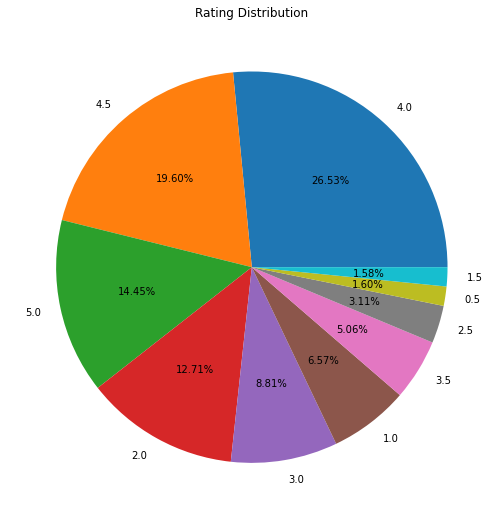

In [15]:
# Get Value Counts for the Rating Column in Train Dataset
xv = df_train['rating'].value_counts()

# Plot a Piechart for Rating Value Counts
label = df_train['rating'].unique()
fig = plt.figure(figsize=(15,9));
plt.pie (xv,data=df_train, autopct='%1.2f%%',labels=label)
plt.show
plt.title ('Rating Distribution')

The piechart shows the overall distribution of movie title ratings by different users. From the piechart, some of the notable facts include:
*  A rating of 4.0 is the most popular rating followed by 4.5. Based on the rating distribution many users prefer to give rating of 4.0-4.5.
* A perfect rating of 5.0 accounts for 14.45% of the total ratings in the dataset. 
* Many users do not like providing low ratings due to reasons not clear from the piechart. 

Show the ratings and the number of movies for each rating.

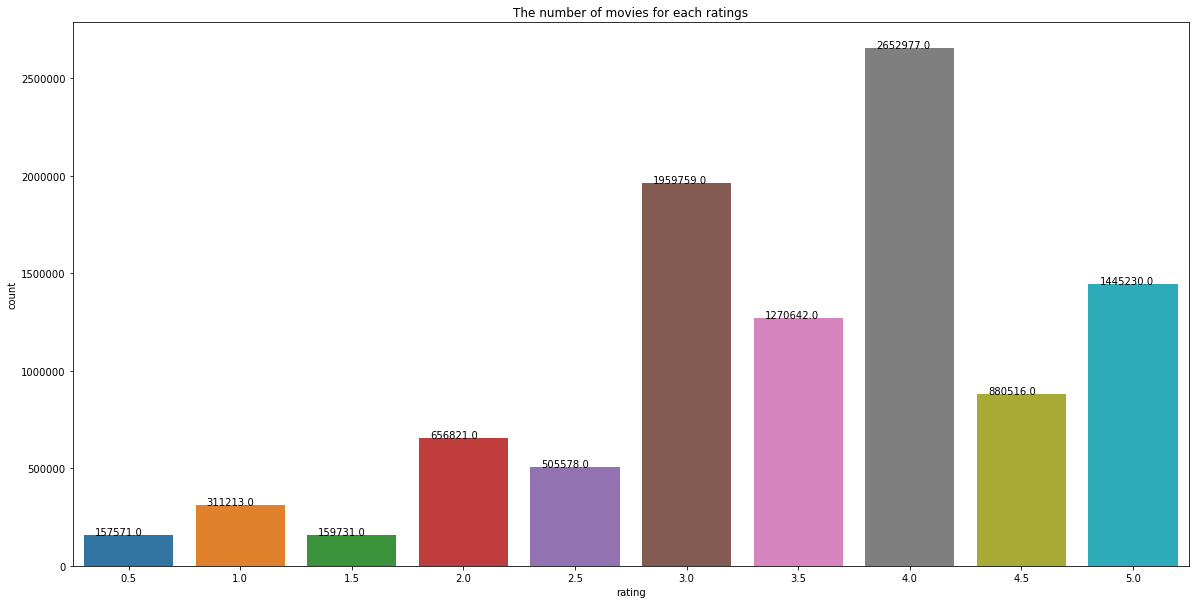

In [16]:
# A Bar Graph Representation of the Ratings Distribution

fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

sns.countplot(ax=ax, x='rating', data=df_train) # Create a countplot to visualise the number of movies per category
ax.set_title("The number of movies for each ratings")
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the tick labels to appear in non-scientific form

# Make the counts appear on the different
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    
# Show the countplot
plt.show()

Most of the movies are rated 3.0 and 4.0. 

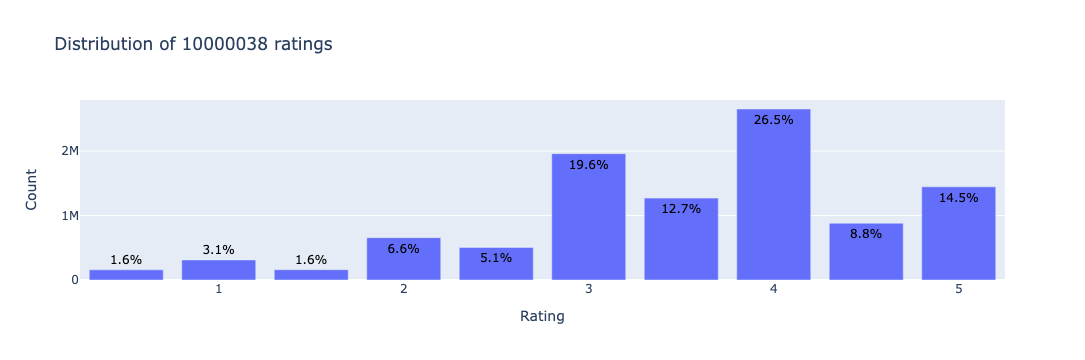

In [18]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df_train['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index, 
              text = ['{:.1f}%'.format(val) for val in (data.values/df_train.shape[0] * 100)],
              textposition = 'auto',
              textfont = dict(color = '#000000'),
              y = data.values,
              )
# Layout Creation
layout = dict(title = 'Distribution of {} ratings'.format(df_train.shape[0]),
             xaxis = dict(title = 'Rating'),
             yaxis = dict(title = 'Count'))

# Create Plot
fig = go.Figure(data = [trace], layout=layout)
fig.show()

## Feature Engineering

Merging all the datasets in this section to make it easy to work with the data in the creation of a content based filtering system. 

In [19]:
new_data = pd.merge(df_train, df_movies, on='movieId', how='left')

new_data.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [18]:
reader = Reader()
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


#### Hyperparameter tuning


In [19]:
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

#cross_validate(svd, data, measures=['RMSE'], cv=5)

In [ ]:
from surprise.model_selection import GridSearchCV

# SVD algorithm



# Create parameter grid
param_grid = {'n_factors':[50,100, 150], 'n_epochs':[20,30], 
              'lr_all':[0.005, 0.01], 'reg_all':[0.02,0.1]}

# Initiate Gridsearch
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fit data
gs.fit(data)

# Parameters
params = gs.best_params['rmse']

# tuned svd
svdtuned = SVD(n_factors = params['n_factors'], n_epochs = params['n_epochs'], lr_all = params['lr_all'],
               reg_all = params['reg_all'])

In [ ]:
trainset = data.build_full_trainset()
print("> OK")

print("Training...")
svd.fit(trainset)
print("Done.")

In [ ]:
# Submission File Creation
predictions = []
for i, row in df_test.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
df_test['Id'] = df_test['userId'].map(str) + '_' + df_test['movieId'].map(str)
results = pd.DataFrame({"Id":df_test['Id'], "rating":predictions})
results.to_csv("submission_csv", index = False)
print("Done")

In [ ]:
submission_df = pd.read_csv("./submission_csv")
submission_df.head()

### End Experiment

In [ ]:
#experiment.end()